# Workflow Interface
## Fine-tuning neural-chat-7b-v3 using Intel(R) Extension for Transformers and OpenFL
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel/openfl/blob/develop/openfl-tutorials/experimental/workflow/LLM/neuralchat/Workflow_Interface_NeuralChat.ipynb)

In this tutorial, we build on the ideas from the [first](https://github.com/securefederatedai/openfl/blob/develop/openfl-tutorials/experimental/workflow/101_MNIST.ipynb) quick start notebook, and demonstrate how to fine-tune a Large Language Model (LLM) in a federated learning workflow. 

We will fine-tune **Intel's [neural-chat-7b](https://huggingface.co/Intel/neural-chat-7b-v1)** model on the [MedQuAD](https://github.com/abachaa/MedQuAD) dataset, an open-source medical question-answer pair dataset collated from 12 NIH websites. To do this, we will leverage the **[Intel(R) Extension for Transformers](https://github.com/intel/intel-extension-for-transformers)**, which extends th [Hugging Face Transformers](https://github.com/huggingface/transformers)  library with added features for optimal performance on Intel hardware..

# What is it?

The workflow interface is a new way of composing federated learning experiments with OpenFL. It was borne through conversations with researchers and existing users who had novel use cases that didn't quite fit the standard horizontal federated learning paradigm. 

## Initial Setup
### Installing Intel(R) Extension for Transformers*
- Start by installing Intel(R) Extension for Transformers* and the required dependencies for the Neural Chat framework. 
For successful installation, please follow the steps outlined in the [Installation Guide](https://github.com/intel/intel-extension-for-transformers/tree/main/intel_extension_for_transformers/neural_chat#installation).
- For additional information, please refer to the [Official Documentation](https://intel.github.io/intel-extension-for-transformers/latest/docs/Welcome.html)

*Note: This Jupyter Notebook has been tested and confirmed to work with `intel-extension-for-transformers==1.2.2`*

### Installing OpenFL
- Lets now install OpenFL and the necessary dependencies for the workflow interface by running the cell below:

In [ ]:
!pip install git+https://github.com/securefederatedai/openfl.git
!pip install -r ../../workflow_interface_requirements.txt
!pip install numpy --upgrade

### Acquiring and preprocessing dataset
We can clone the dataset directly from the [MedQuAD repository](https://github.com/abachaa/MedQuAD)

In [ ]:
!rm -rf MedQuAD
!git clone https://github.com/abachaa/MedQuAD.git

From here, we provide a preprocessing code to verify the dataset and prepare it to be readily ingestible by the fine-tuning pipeline

In [ ]:
from preprocess_dataset import xml_to_json

# User input for folder paths
input_base_folder = "./MedQuAD/"
subfolders = ["1_CancerGov_QA", "2_GARD_QA", "3_GHR_QA", "4_MPlus_Health_Topics_QA",
                  "5_NIDDK_QA", "6_NINDS_QA", "7_SeniorHealth_QA", "8_NHLBI_QA_XML", "9_CDC_QA"]
output_folder = "./"

xml_to_json(input_base_folder, subfolders, output_folder, verify_hash=1)

## Import libraries

In [ ]:
import torch

from transformers import (
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments, 
    DataCollatorForSeq2Seq,
)

from intel_extension_for_transformers.neural_chat.config import (
    ModelArguments,
    DataArguments,
    FinetuningArguments,
    TextGenerationFinetuningConfig,
)

from intel_extension_for_transformers.llm.finetuning.finetuning import Finetuning
from intel_extension_for_transformers.llm.finetuning.data_utils import preprocess_dataset

from peft import LoraConfig, TaskType, get_peft_model

from datasets import DatasetDict

In [ ]:
import random
import numpy as np
import torch

# Set a seed value
seed = 42 

# Python's random module
random.seed(seed)

# Numpy
np.random.seed(seed)

# PyTorch
torch.manual_seed(seed)

# Transformers
from transformers import set_seed
set_seed(seed)

## Initialize arguments and configurations

In [ ]:
model_args = ModelArguments(model_name_or_path="Intel/neural-chat-7b-v3-1")

data_args = DataArguments(
    train_file="medquad_alpaca_train.json",
    validation_split_percentage=20,
)

training_args = TrainingArguments(
    output_dir='./local_model',
    do_train=True,
    do_eval=True,
    num_train_epochs=1,
    overwrite_output_dir=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    save_strategy="no",
    log_level="info",
    save_total_limit=2,
    bf16=True,
    disable_tqdm=True,
)

finetune_args = FinetuningArguments()
finetune_cfg = TextGenerationFinetuningConfig(
            model_args=model_args,
            data_args=data_args,
            training_args=training_args,
            finetune_args=finetune_args,
        )

finetuning = Finetuning(finetune_cfg)
config = finetuning.load_model_config(model_args)

## Load and initialize model

In [ ]:
model_dtype = (
    torch.float16 if training_args.fp16 else
        (torch.bfloat16 if training_args.bf16 else torch.float32)
)

model = AutoModelForCausalLM.from_pretrained(
    model_args.model_name_or_path,
    config=config,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
    trust_remote_code=True if model_args.trust_remote_code else None,
    torch_dtype=model_dtype,
    low_cpu_mem_usage=True,
)

target_modules = finetuning.find_all_linear_names(model)

peft_config = LoraConfig(
    r=finetune_args.lora_rank,
    lora_alpha=finetune_args.lora_alpha,
    lora_dropout=finetune_args.lora_dropout,
    target_modules=target_modules,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, peft_config)
if model_dtype == torch.bfloat16:
    model = model.to(model_dtype)
model.print_trainable_parameters()

## Set up tokenizer

In [ ]:
tokenizer = finetuning.load_tokenizer(model_args)
tokenizer.padding_side = "left" # allow batched inference, while mpt series don't support

embedding_size = model.get_input_embeddings().weight.shape[0]
if len(tokenizer) > embedding_size:
    model.resize_token_embeddings(len(tokenizer))

if (
    hasattr(model.generation_config, "pad_token_id")
    and model.generation_config.pad_token_id is not None
):
    tokenizer.pad_token_id = model.generation_config.pad_token_id
if (
    hasattr(model.generation_config, "eos_token_id")
    and model.generation_config.eos_token_id is not None
):
    tokenizer.eos_token_id = model.generation_config.eos_token_id
if (
    hasattr(model.generation_config, "bos_token_id")
    and model.generation_config.bos_token_id is not None
):
    tokenizer.bos_token_id = model.generation_config.bos_token_id

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

## Load and preprocess dataset

In [ ]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
)

raw_datasets = finetuning.load_dataset(data_args, model_args, training_args)

raw_datasets, preprocess_function = preprocess_dataset(raw_datasets, tokenizer, data_args, finetune_args)
column_names = list(raw_datasets["train"].features)


with training_args.main_process_first(desc="dataset map pre-processing"):
    tokenized_datasets = raw_datasets.map(
        preprocess_function,
        batched=True,
        remove_columns=column_names,
        load_from_cache_file=not data_args.overwrite_cache,
    )

if training_args.do_eval:
    if "validation" not in tokenized_datasets:
        raise ValueError("--do_eval requires a validation dataset")

    eval_dataset = tokenized_datasets["validation"]
    if data_args.max_eval_samples is not None:
        eval_dataset = eval_dataset.select(range(data_args.max_eval_samples))

if training_args.do_train:
    if "train" not in tokenized_datasets:
        raise ValueError("--do_train requires a train dataset")
    train_dataset = tokenized_datasets["train"]
    if data_args.max_train_samples is not None:
        train_dataset = train_dataset.select(range(data_args.max_train_samples))

dataset = DatasetDict({
    'train': train_dataset,
    'eval': eval_dataset,
})

Next we import the `FLSpec`, `LocalRuntime`, and placement decorators.

- `FLSpec` – Defines the flow specification. User defined flows are subclasses of this.
- `Runtime` – Defines where the flow runs, infrastructure for task transitions (how information gets sent). The `LocalRuntime` runs the flow on a single node.
- `aggregator/collaborator` - placement decorators that define where the task will be assigned

In [ ]:
from copy import deepcopy

from openfl.experimental.workflow.interface import FLSpec, Aggregator, Collaborator
from openfl.experimental.workflow.runtime import LocalRuntime
from openfl.experimental.workflow.placement import aggregator, collaborator

import numpy as np


def FedAvg(models, weights=None):
    new_model = deepcopy(models[0])
    state_dicts = [model.state_dict() for model in models]
    state_dict = new_model.state_dict()
    for key in models[1].state_dict():
        state_dict[key] = torch.from_numpy(np.average([state[key].numpy() for state in state_dicts],
                                                      axis=0, 
                                                      weights=weights))
    new_model.load_state_dict(state_dict)
    return new_model

Now we come to the flow definition. The OpenFL Workflow Interface adopts the conventions set by Metaflow, that every workflow begins with `start` and concludes with the `end` task. The aggregator begins with an optionally passed in model and optimizer. The aggregator begins the flow with the `start` task, where the list of collaborators is extracted from the runtime (`self.collaborators = self.runtime.collaborators`) and is then used as the list of participants to run the task listed in `self.next`, `aggregated_model_validation`. The model, optimizer, and anything that is not explicitly excluded from the next function will be passed from the `start` function on the aggregator to the `aggregated_model_validation` task on the collaborator. Where the tasks run is determined by the placement decorator that precedes each task definition (`@aggregator` or `@collaborator`). Once each of the collaborators (defined in the runtime) complete the `aggregated_model_validation` task, they pass their current state onto the `train` task, from `train` to `local_model_validation`, and then finally to `join` at the aggregator. It is in `join` that an average is taken of the model weights, and the next round can begin.

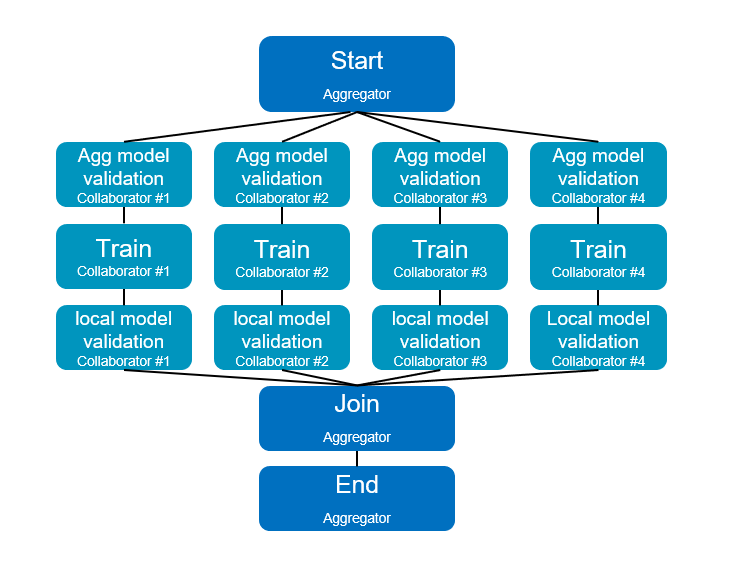

In [ ]:
class FederatedFlow(FLSpec):

    def __init__(self, model = None, optimizer = None, rounds=3, **kwargs):
        super().__init__(**kwargs)
        if model is not None:
            self.model = model
            self.optimizer = optimizer
        else:
            raise ValueError("No model inputted")
            
        self.rounds = rounds

    @aggregator
    def start(self):
        print(f'Performing initialization for model')
        self.collaborators = self.runtime.collaborators
        self.private = 10
        self.current_round = 0
        self.next(self.aggregated_model_validation,foreach='collaborators',exclude=['private'])

    @collaborator
    def aggregated_model_validation(self):
        print(f'Performing aggregated model validation for collaborator {self.input}')
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.eval_dataset,
            tokenizer=tokenizer,
            data_collator=data_collator,
        )
        from transformers.trainer_callback import PrinterCallback
        trainer.remove_callback(PrinterCallback)
        out = trainer.evaluate()
        self.agg_validation_score = out['eval_loss']
        print(f'{self.input} value of {self.agg_validation_score}')
        self.next(self.train)

    @collaborator
    def train(self):       
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.eval_dataset,
            tokenizer=tokenizer,
            data_collator=data_collator,
        )

        out = trainer.train()  

        self.loss = out.training_loss
        trainer.save_model()
        self.training_completed = True
        self.next(self.local_model_validation)

    @collaborator
    def local_model_validation(self):
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.eval_dataset,
            tokenizer=tokenizer,
            data_collator=data_collator,
        )
        out = trainer.evaluate()
        self.local_validation_score = out['eval_loss']
        print(f'Doing local model validation for collaborator {self.input}')
        self.next(self.join, exclude=['training_completed'])

    @aggregator
    def join(self,inputs):
        self.average_loss = sum(input.loss for input in inputs)/len(inputs)
        self.aggregated_model_accuracy = sum(input.agg_validation_score for input in inputs)/len(inputs)
        self.local_model_accuracy = sum(input.local_validation_score for input in inputs)/len(inputs)
        print(f'Average aggregated model validation values = {self.aggregated_model_accuracy}')
        print(f'Average training loss = {self.average_loss}')
        print(f'Average local model validation values = {self.local_model_accuracy}')
        
        self.model = FedAvg([input.model for input in inputs])
        
        self.model.save_pretrained('./aggregated/model')
        tokenizer.save_pretrained('./aggregated/tokenizer')
        self.current_round += 1
        if self.current_round < self.rounds:
            self.next(self.aggregated_model_validation, foreach='collaborators', exclude=['private'])
        else:
            self.next(self.end)
        
    @aggregator
    def end(self):
        print(f'This is the end of the flow')

You'll notice in the `FederatedFlow` definition above that there were certain attributes that the flow was not initialized with, namely the `train_dataset` and `eval_dataset` for each of the collaborators. These are **private_attributes** that are exposed only throughout the runtime. Each participant has it's own set of private attributes: a dictionary where the key is the attribute name, and the value is the object that will be made accessible through that participant's task. 

Below, we segment shards of the MedQuAD dataset for **three collaborators**: Portland, Seattle, and Chandler. Each has their own slice of the dataset that's accessible via the `train_dataset` or `eval_dataset` attribute. Note that the private attributes are flexible, and you can choose to pass in a completely different type of object to any of the collaborators or aggregator (with an arbitrary name). These private attributes will always be filtered out of the current state when transferring from collaborator to aggregator, or vice versa.  

In [ ]:
# Setup participants
aggregator = Aggregator()
aggregator.private_attributes = {}

# Setup collaborators with private attributes
collaborator_names = ['Portland', 'Seattle', 'Chandler']
collaborators = [Collaborator(name=name) for name in collaborator_names]

for idx, collaborator in enumerate(collaborators):
    # Set the private attributes of the Collaborator to include their specific training and testing data loaders
    collaborator.private_attributes = {
            'train_dataset': dataset['train'].shard(num_shards=len(collaborators), index=idx),
            'eval_dataset': dataset['eval'].shard(num_shards=len(collaborators), index=idx)
    }

local_runtime = LocalRuntime(aggregator=aggregator, collaborators=collaborators, backend='single_process')
print(f'Local runtime collaborators = {local_runtime.collaborators}')

Now that we have our flow and runtime defined, let's run the experiment! 

In [ ]:
flflow = FederatedFlow(model)
flflow.runtime = local_runtime
flflow.run()

Now that the flow has completed, let's get the final model accuracy:

In [ ]:
print(f'\nFinal aggregated model accuracy for {flflow.rounds} rounds of training: {flflow.aggregated_model_accuracy}')

# Congratulations!
Now that you've completed this notebook, check out our [other tutorials](https://github.com/securefederatedai/openfl/tree/develop/openfl-tutorials/experimental/workflow), including:

- Using the LocalRuntime Ray Backend for dedicated GPU access
- Vertical Federated Learning
- Model Watermarking
- Differential Privacy
- And More!

# Reference
    @ARTICLE{BenAbacha-BMC-2019,    
          author    = {Asma {Ben Abacha} and Dina Demner{-}Fushman},
          title     = {A Question-Entailment Approach to Question Answering},
          journal = {{BMC} Bioinform.}, 
          volume    = {20},
          number    = {1},
          pages     = {511:1--511:23},
          year      = {2019},
          url       = {https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3119-4}
           } 
